In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_format = 'svg'

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import torch
import pickle
from attention_one_layer_k_fold import KinaseSubstrateRelationshipNN
from NNInterface import NNInterface
rcParams['font.family'] = 'Palatino'
rcParams['font.size'] = 13
import sklearn

Using device cpu


In [4]:
config = {
        "learning_rate": 0.003,
        "batch_size": 57,
        "ll_size": 20,
        "emb_dim": 22,
        "num_epochs": 15,
        "n_gram": 1,
        "lr_decay_amt": 0.95,
        "lr_decay_freq": 1,
        "num_conv_layers": 1,
        "dropout_pr": 0.37,
        "site_param_dict": {"kernels": [8], "out_lengths": [8], "out_channels": [20]},
        "kin_param_dict": {"kernels": [80], "out_lengths": [8], "out_channels": [20]},
    }

learning_rate = config['learning_rate']
batch_size = config['batch_size']
ll_size = config['ll_size']
emb_dim = config['emb_dim']
num_epochs = config['num_epochs']
lr_decay_amt = config['lr_decay_amt']
lr_decay_freq = config['lr_decay_freq']
n = n_gram = config['n_gram']
num_conv_layers = config['num_conv_layers']
site_param_dict = config['site_param_dict']
kin_param_dict = config['kin_param_dict']
dropout_pr = config['dropout_pr']


In [37]:
# Read in model and data

torch.load("bin/current_best_model.pkl")
train_loader = pickle.load(open("bin/train_loader.pkl", "rb"))
val_loader = pickle.load(open("bin/val_loader.pkl", "rb"))

num_classes = 1
device = "cpu"

model = KinaseSubstrateRelationshipNN(num_classes=num_classes, inp_size=NNInterface.get_input_size(train_loader), ll_size=ll_size, emb_dim=emb_dim, num_conv_layers=num_conv_layers, site_param_dict=site_param_dict, kin_param_dict=kin_param_dict).to(device)
model.load_state_dict(torch.load("bin/current_best_model.pkl", map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
data = val_loader.dataset.data[:500]
target = val_loader.dataset.target[:500]
class_ = val_loader.dataset.class_[:500]

In [38]:
# Get predictions

# with torch.no_grad():
#     model.eval()
#     preds = torch.sigmoid(model(data, target)).cpu().numpy().tolist()
#     labels = class_.cpu().numpy().tolist()

probs = pickle.load(open("bin/probs.pkl", "rb"))
labels_ = pickle.load(open("bin/labels.pkl", "rb"))

In [31]:
probs

array([0.84010726, 0.92425054, 0.51556224, ..., 0.00386032, 0.6556295 ,
       0.7784108 ], dtype=float32)

Text(0.5, 1.0, 'Model Predictions')

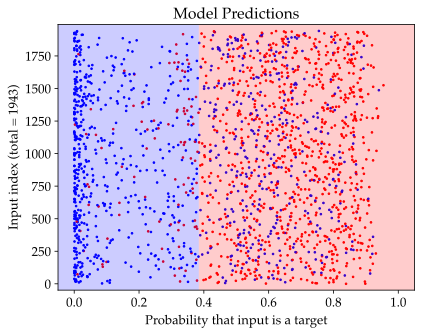

In [58]:
colors = ['r' if label == 1 else 'b' for label in labels_]
xlm = [-0.05, 1.05]
ylm = [-0.025*len(probs), 1.025*len(probs)]
plt.scatter(probs, range(len(probs)), c=colors, s=3)
plt.axhspan(ylm[0], ylm[1], -2, 0.395, facecolor='b', alpha=0.2)
plt.axhspan(ylm[0], ylm[1], 0.395, 2, facecolor='r', alpha=0.2)
plt.xlim(xlm)
plt.ylim(ylm)
plt.xlabel("Probability that input is a target")
plt.ylabel(f"Input index (total = {len(probs)})")
plt.title("Model Predictions")

In [39]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(labels_, probs)

p = sum(labels_)
n = len(labels_) - p

fp = p*fpr
tp = p*tpr
fn = n*(1-tpr)
tn = n*(1-fpr)
acc = (tp + tn)/(fp + tp + fn + tn)


Text(0.5, 1.0, 'ROC Curve and Accuracy Curve\n(Area under ROC = 0.821)')

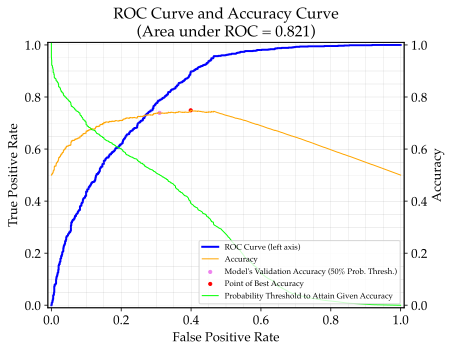

In [57]:
# sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(labels, [1 if pred > 0.5 else 0 for pred in preds])).plot()
fig, ax = plt.subplots()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")

rax = ax.twinx()
ax.plot(fpr, tpr, label = "ROC Curve (left axis)", color = "blue", linewidth=2)
plt.ylabel("Accuracy")
rax.plot(fpr, acc, label = "Accuracy", color = "orange", linewidth=1)
rax.scatter(fpr[[round(x, 3) for x in thresholds.tolist()].index(0.501)], 0.739, label = "Model's Validation Accuracy (50% Prob. Thresh.)", color = "violet", s = 10)
rax.scatter(fpr[np.argmax(acc)], acc[np.argmax(acc)], s = 10, label = "Point of Best Accuracy", color = "red")


# plt.hlines(acc[np.argmax(acc)], fpr[np.argmax(acc)], 2, color = "red", linestyles=['dashed'], linewidth = 0.15)
# plt.vlines(fpr[np.argmax(acc)], -1, acc[np.argmax(acc)], color = "red", linestyles=['dashed'], linewidth = 0.15)
rax.plot(fpr, thresholds, color = "lime", label = "Probability Threshold to Attain Given Accuracy", linewidth = 1)

handles, labels = ax.get_legend_handles_labels()
handlesr, labelsr = rax.get_legend_handles_labels()
handles = handles + handlesr
labels = labels + labelsr
plt.legend(handles, labels, loc="lower right", prop={'size': 8})

ax.set_xlim(-0.01, 1.01)
ax.set_ylim(-0.01, 1.01)
rax.set_xlim(-0.01, 1.01)
rax.set_ylim(-0.01, 1.01)

# Grid
ax.vlines([x/100 for x in range(0, 101, 5)], -1, 2, color = 'grey', linewidth = 0.1)
ax.hlines([x/100 for x in range(0, 101, 5)], -1, 2, color = 'grey', linewidth = 0.1)

plt.title(f"ROC Curve and Accuracy Curve\n(Area under ROC = {round(sklearn.metrics.roc_auc_score(labels_, probs), 3)})")

In [56]:
thresholds

array([1.9543004e+00, 9.5430040e-01, 9.4009101e-01, 9.2223376e-01,
       9.2208070e-01, 9.2086929e-01, 9.1983658e-01, 9.1418749e-01,
       9.1327208e-01, 9.0799540e-01, 9.0749592e-01, 8.9392918e-01,
       8.9385808e-01, 8.9348775e-01, 8.9258820e-01, 8.8642895e-01,
       8.8619244e-01, 8.7486100e-01, 8.7441438e-01, 8.7251925e-01,
       8.7214965e-01, 8.7030852e-01, 8.6961347e-01, 8.6949378e-01,
       8.6922598e-01, 8.6278284e-01, 8.6255777e-01, 8.6165661e-01,
       8.6146486e-01, 8.6113942e-01, 8.6090463e-01, 8.5819983e-01,
       8.5810608e-01, 8.5617602e-01, 8.5575688e-01, 8.5543931e-01,
       8.5447568e-01, 8.5018688e-01, 8.5002053e-01, 8.3959460e-01,
       8.3912653e-01, 8.3842826e-01, 8.3840436e-01, 8.3617616e-01,
       8.3501023e-01, 8.3422893e-01, 8.3402205e-01, 8.2746559e-01,
       8.2695866e-01, 8.2649952e-01, 8.2584751e-01, 8.2134271e-01,
       8.2117403e-01, 8.1847894e-01, 8.1838584e-01, 8.1630766e-01,
       8.1628746e-01, 8.1581509e-01, 8.1551504e-01, 8.1506884e

In [47]:
cm = sklearn.metrics.confusion_matrix(labels_, probs)

sklearn.metrics.ConfusionMatrixDisplay()

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [60]:
thresholds[503]

0.39159095

In [ ]:
v = val_loader.dataset.target.numpy()

In [ ]:
sv = set(tuple([tuple(x) for x in np.unique(v, axis = 0).tolist()]))

In [ ]:
tv = set(tuple([tuple(x) for x in np.unique(t, axis = 0).tolist()]))

In [ ]:
set.intersection(sv, tv)